In [1]:

import pandas as pd
import gensim
from gensim import corpora
import json, glob
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# import spacy
import pyLDAvis
import pyLDAvis.gensim
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
df = pd.read_csv("abc.csv")

In [3]:
df['lemmatized_text']

0        would like share hope create thread think call...
1        hello new f post menopausal go premature ovari...
2        hi rhoda decide go hrt use patch week make dif...
3        oh god urine come kegel get go lady run leg ti...
4        hello almost year half since last menstrual cy...
                               ...                        
25313    know worth mention common put mg day oral prog...
25314                               look one thank mention
25315                                                thank
25316                trust right professional know exactly
25317    yes menopause estrogen decline despite highs l...
Name: lemmatized_text, Length: 25318, dtype: object

In [4]:
df = df.dropna()

In [5]:
df.shape

(25147, 6)

In [6]:
temp = [doc.split() for doc in df['lemmatized_text']]

In [7]:
tokens = [[word for word in sublist if len(word) > 1 and 'www' not in word and 'https' not in word] for sublist in temp]

# Bigrams and Trigrams

In [8]:
bp = gensim.models.Phrases(tokens, min_count=5,threshold=50)
tp = gensim.models.Phrases(bp[tokens],threshold=10)

b_obj = gensim.models.phrases.Phraser(bp)
t_obj = gensim.models.phrases.Phraser(tp)

In [9]:
# data_bg = make_bigrams(tokens)
# data_tg = make_trigram(data_bg)

data_bg = list(b_obj[tokens])
data_tg = list(t_obj[data_bg])

In [10]:
from gensim.models import TfidfModel
dictionary = corpora.Dictionary(data_tg)
print(len(dictionary))

23282


In [11]:
corpus = [dictionary.doc2bow(doc) for doc in data_tg]

In [12]:
tfidf = TfidfModel(corpus, id2word = dictionary)
low_value = 0.03
words = []
words_missing_in_tfidf = []



In [13]:
for i in range(0,len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    for item in drops:
        words.append(dictionary[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [14]:
num_topics = 3
lda_model = gensim.models.ldamodel.LdaModel(corpus, 
                                            num_topics=num_topics, 
                                            id2word=dictionary, 
                                            random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [15]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds="mmds", R=50)
vis

/Users/aokiji/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.243513  0.079189       1        1  48.718987
2     -0.000527 -0.257273       2        1  35.236845
0     -0.242986  0.178084       3        1  16.044167, topic_info=        Term         Freq        Total Category  logprob  loglift
347   doctor  2923.000000  2923.000000  Default  50.0000  50.0000
171  hormone  1647.000000  1647.000000  Default  49.0000  49.0000
86       day  2882.000000  2882.000000  Default  48.0000  48.0000
126    start  2670.000000  2670.000000  Default  47.0000  47.0000
369     help  2717.000000  2717.000000  Default  46.0000  46.0000
..       ...          ...          ...      ...      ...      ...
80      also   371.819758  3135.337019   Topic3  -5.4712  -0.3023
28       say   345.061852  2695.155177   Topic3  -5.5459  -0.2257
293      low   262.987468   616.569541   Topic3  -5.8175   0.9778
40     would   324.257447  2568.275343   Topic3  -5.6080  -0.2396
175     many   248.558380   959.249824   Topic3  -5.8739   0.4794

[322 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
505       2  0.956509    add
505       3  0.043008    add
2032      1  0.001728   adhd
2032      2  0.997308   adhd
2032      3  0.001728   adhd
...     ...       ...    ...
199       2  0.623505   year
2435      2  0.998545    yep
708       1  0.353418    yes
708       2  0.646608    yes
275       1  0.998471  young

[383 rows x 3 columns], R=50, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [ ]:

imp_topic1 = ["think","know","help","thank","love","female","hard","year","try","great"] 
imp_topic2 = ["peri","period","bad","feel","anxiety","ADHD","exercice","weight","back","start"]
imp_topic3 = ["doctor","hormone","hrt","symptom","test","progestrone","estrogen","treatment","prescibe","cancer"]

In [15]:
# from tqdm import tqdm
# coherence_scores = []
# for num_topics in tqdm(range(2, 30)):
#     lda_model = gensim.models.ldamodel.LdaModel(corpus, 
#                                                 num_topics=num_topics, 
#                                                 id2word=dictionary, 
#                                                 random_state=100,
#                                                update_every=1,
#                                                chunksize=100,
#                                                passes=10,
#                                                alpha="auto")
#     coherence_model = CoherenceModel(model=lda_model, 
#                                      texts=data_tg, 
#                                      dictionary=dictionary, 
#                                      coherence='c_v')
#     coherence_score = coherence_model.get_coherence()
#     coherence_scores.append(coherence_score)

100%|███████████████████████████████████████████| 28/28 [33:38<00:00, 72.09s/it]


# coherence_scores is highest for 3 and hence we will go for 3 topics

# WordCloud

In [25]:
# To check words in a given topic
topic_id = 2
words = lda_model.show_topic(topic_id,topn=50)
for word,prob in words:
    print(word)

get
take
day
help
start
well
peri
use
also
period
try
go
still
year
month
work
bad
feel
one
week
time
sleep
like
yes
stop
body
long
symptom
really
since
much
hope
last
change
weight
back
eat
anxiety
thing
lot
definitely
keep
two
issue
even
seem
first
exercise
adhd
bit


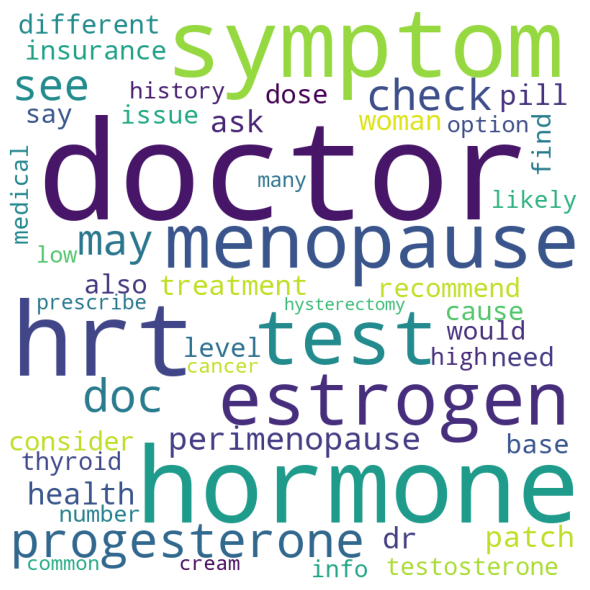

In [29]:
# To create word cloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary mapping words to their frequency
word_freq = {}
for word, prob in words:
    word_freq[word] = prob

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', 
                      min_font_size=10).generate_from_frequencies(word_freq)

# Display the generated image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


# Sentiment Analysis

In [30]:
top_topics = lda_model.show_topics(num_topics=3)

In [31]:
sia = SentimentIntensityAnalyzer()
sentiments = []
for topic in top_topics:
    topic_id = topic[0]
    top_words = [word for word, _ in lda_model.show_topic(topic_id, topn=20)]
    topic_words = ' '.join(top_words)
    topic_sentiment = sia.polarity_scores(topic_words)
    sentiments.append(topic_sentiment)

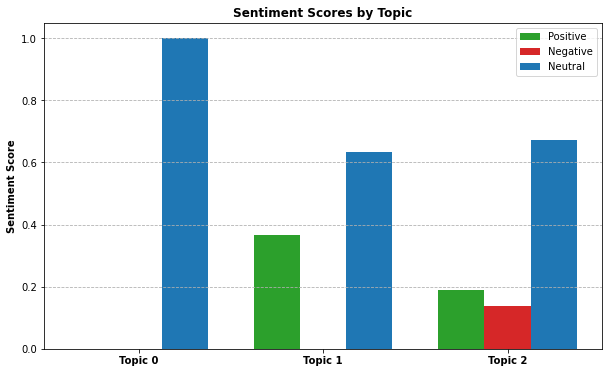

In [34]:
import numpy as np
import matplotlib.pyplot as plt
pos_scores = [sentiment['pos'] for sentiment in sentiments]
neg_scores = [sentiment['neg'] for sentiment in sentiments]
neu_scores = [sentiment['neu'] for sentiment in sentiments]


labels = [f"Topic {i}" for i in range(len(top_topics))]
x = np.arange(len(labels))
bar_width = 0.25
colors = ['#2ca02c', '#d62728', '#1f77b4']

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - bar_width, pos_scores, bar_width, label='Positive', color=colors[0])
ax.bar(x, neg_scores, bar_width, label='Negative', color=colors[1])
ax.bar(x + bar_width, neu_scores, bar_width, label='Neutral', color=colors[2])

ax.set_ylabel('Sentiment Score', weight='bold')
ax.set_title('Sentiment Scores by Topic', weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, weight='bold')
ax.legend()

ax.grid(axis='y', linestyle='--')

plt.show()
